# Importing Modules

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import math
import imageio

# Define Neural Network

In [4]:
class FCN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Advection equation 

$ -\left( v(x) \frac{\partial u}{\partial x} + v(y) \frac{\partial u}{\partial y} \right)$


In [5]:
mux = 0.1 
muy = 0.05
def u0(x):
    return np.exp(-100*(x-0.2)**2) # gaussian wave
def u_true(x,t):
    return  u0(x - mux * t)

# 2D advection equation 
def u_2d_true(x, y, t):
        return u0(x - mux * t) * u0(y - muy * t)

# Observational input Data

In [6]:
nx,ny,nt = 100,100,2

xrmeshshape: (100, 100, 2) 
 yrmeshshape: (100, 100, 2) 
 trmeshshape: (100, 100, 2)


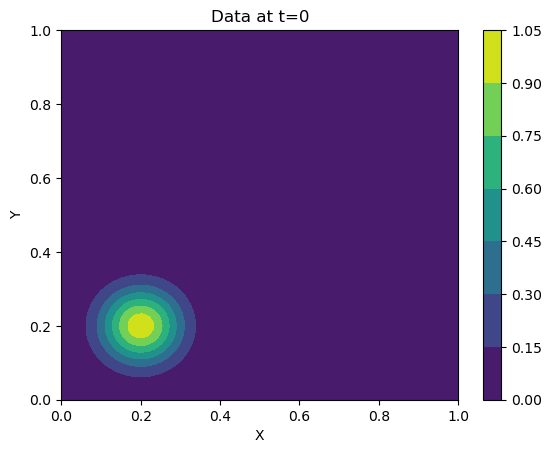

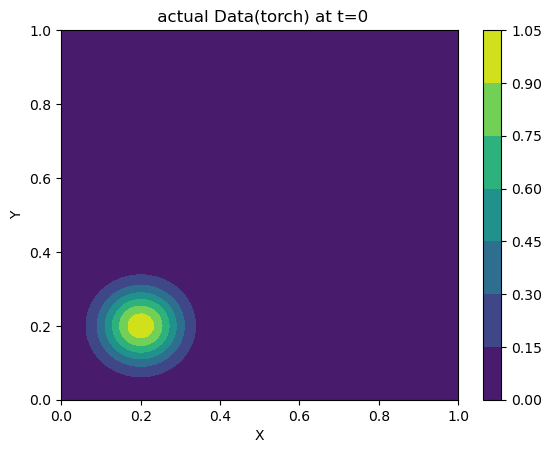

rin_data shape: torch.Size([20000, 3]) 
 rout_data shape: torch.Size([20000, 1])


In [7]:
xr = np.linspace(0,1,nx)
yr = np.linspace(0,1,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

ur = u_2d_true(xrmesh,yrmesh,trmesh)

#print(ur[:,:,0].shape)
# print(ur[0,:,:].shape)
# print(xrmesh[0,:,:].shape)
#plot ur
plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Data at t=0')
plt.colorbar()
plt.show()

# Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_data = torch.tensor(rin_data).float()
rout_data = torch.tensor(ur).float().reshape(-1,1)

rout_data2 = rout_data.numpy().reshape(nx,ny,nt)
plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], rout_data2[:,:,0])
plt.xlabel('X')
plt.ylabel('Y')
plt.title(' actual Data(torch) at t=0')
plt.colorbar()
plt.show()
print(f'rin_data shape: {rin_data.shape} \n rout_data shape: {rout_data.shape}')

# Fitting a Neural Network to the observational data

In [8]:
torch.manual_seed(123)
model = FCN(3,1,32,3)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
for i in range(5):
    optimizer.zero_grad()
    uh = model(rin_data)
    
    loss = torch.mean((uh-rout_data)**2)
    loss.backward()
    optimizer.step()
    if (i+1) % 1000 == 0:
        print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
        

print(uh.shape, rout_data.shape, rin_data.shape)

Epoch: 1000/10000, Loss: 0.007511064875870943


KeyboardInterrupt: 

To check the behavior of the fitted model, we plot model output as a function of x and y for times between t=0 and t=3, and compare it to observed data and the true function.

torch.Size([100000, 1])


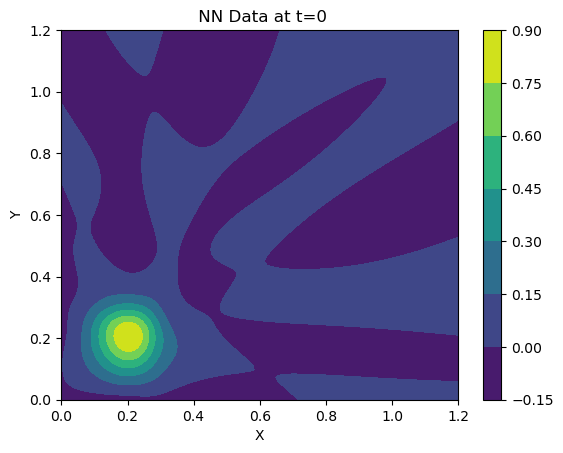

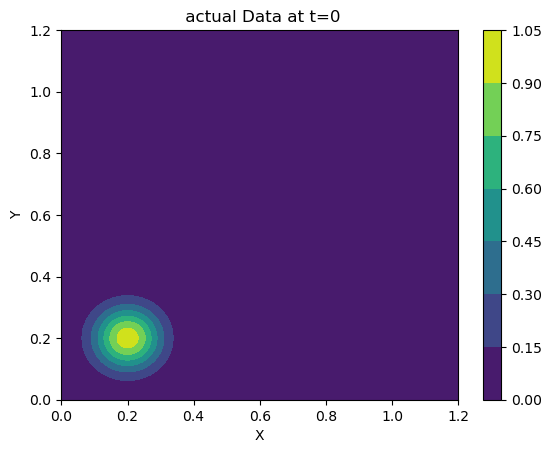

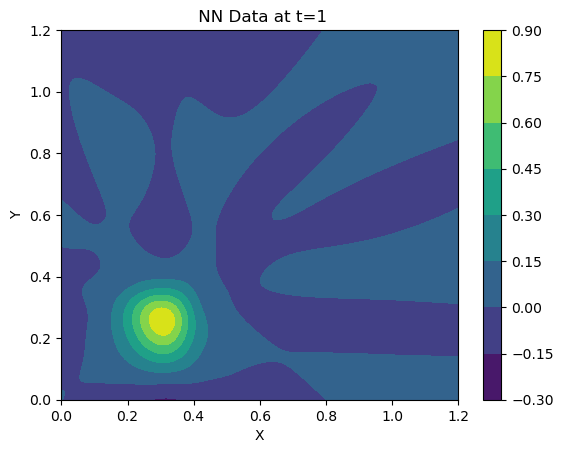

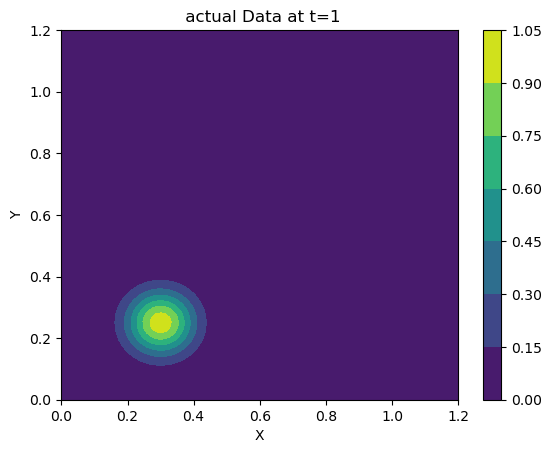

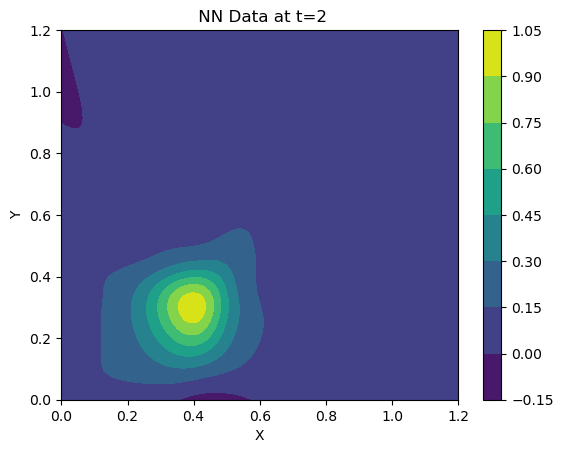

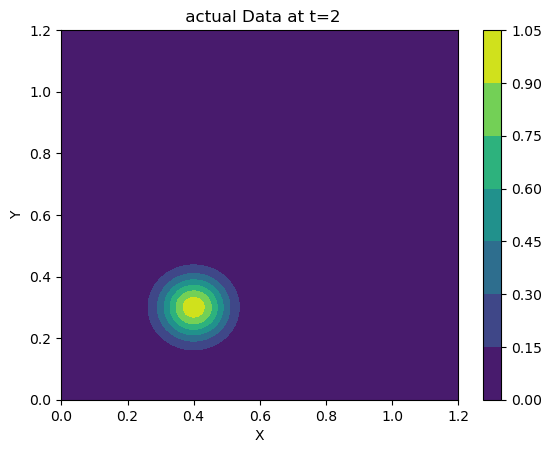

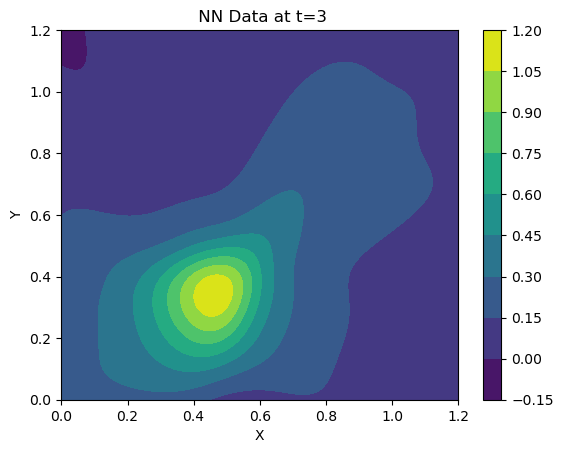

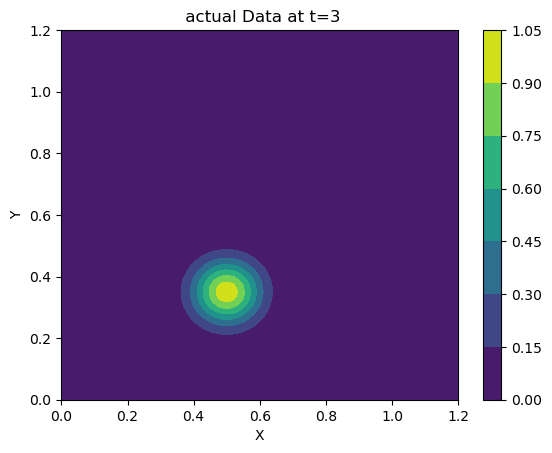

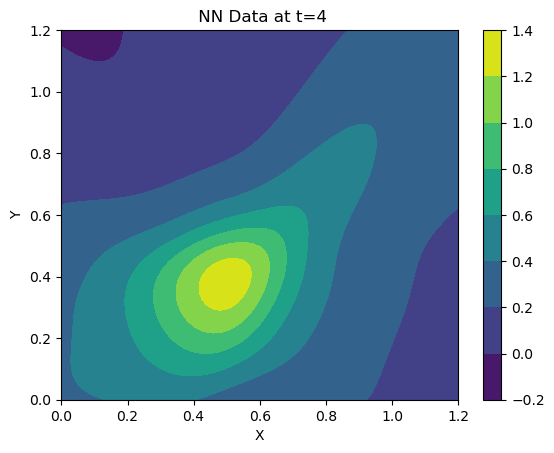

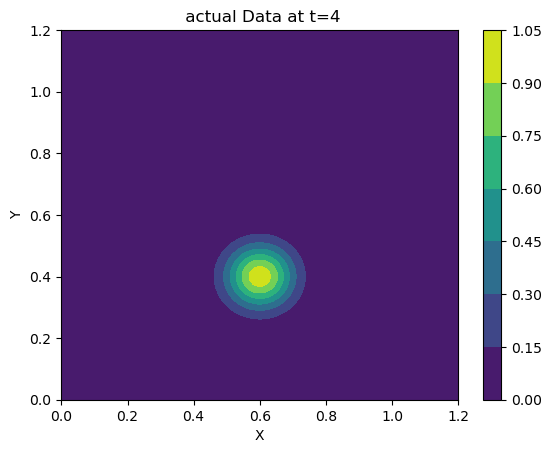

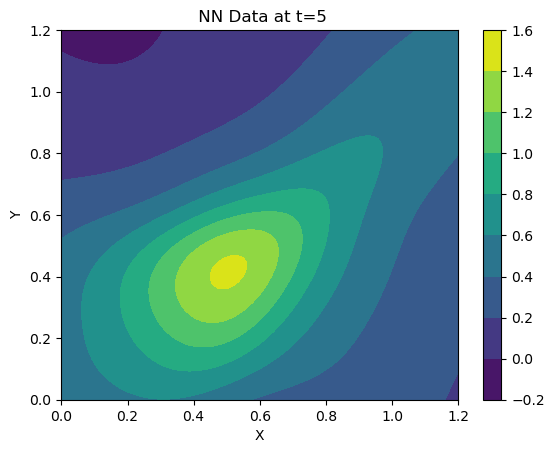

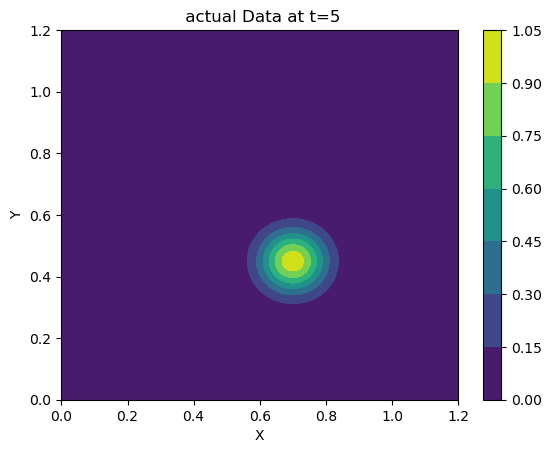

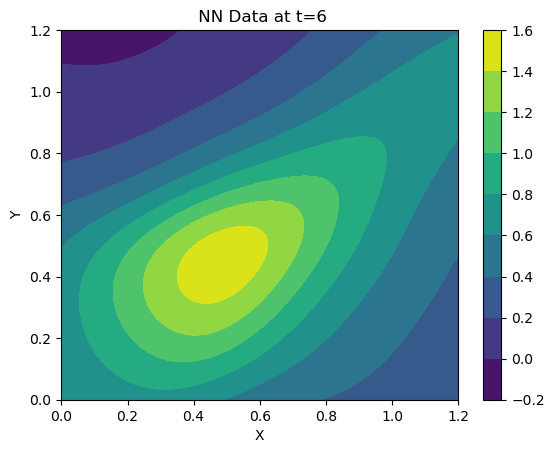

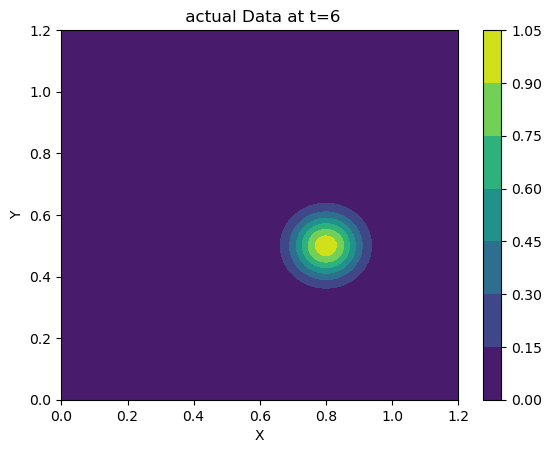

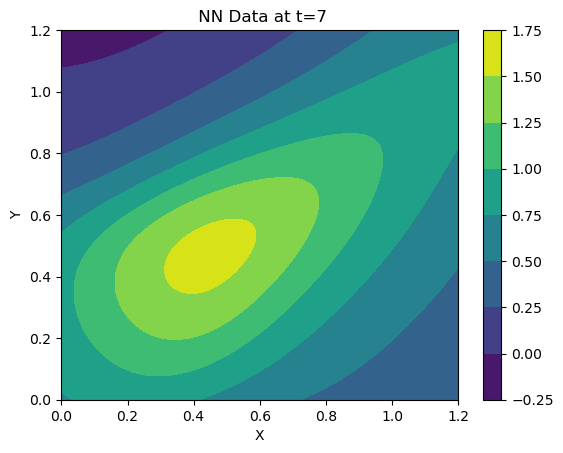

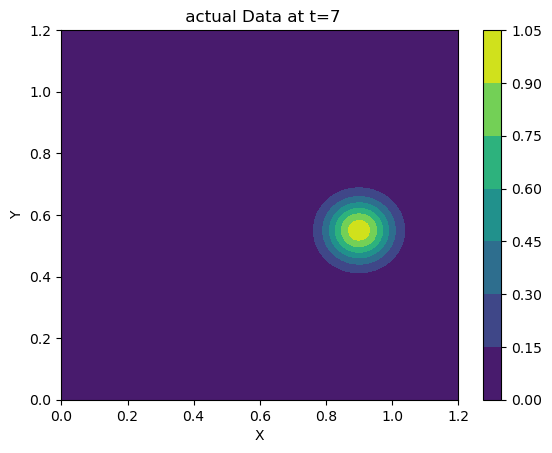

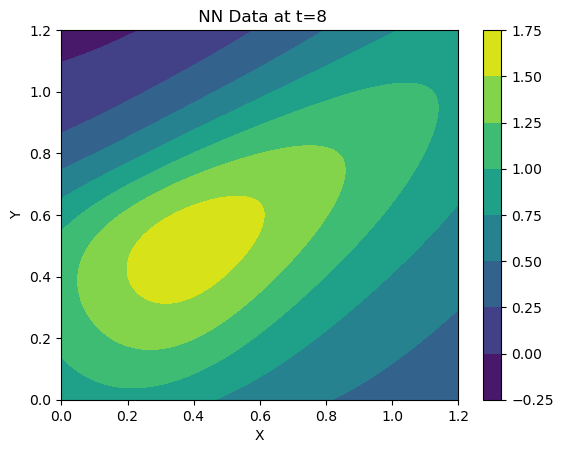

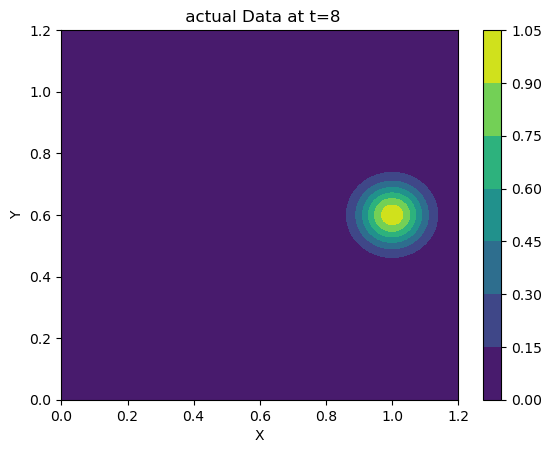

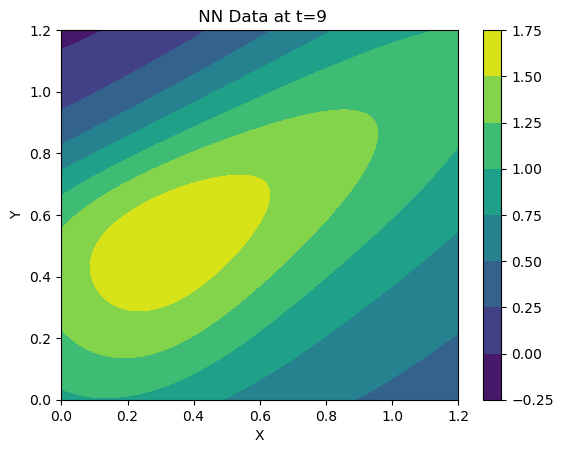

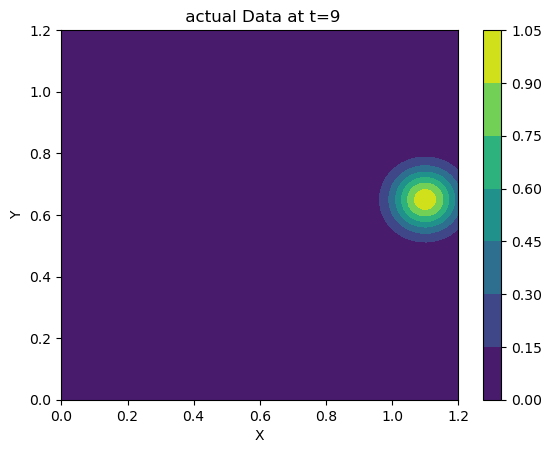

In [9]:
'''
Generate and save the plots for tt = 0-11
'''
cwd = os.getcwd()
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'nn_plot')

# Create the directories if they don't exist
os.makedirs(nn_plot_dir, exist_ok=True)
os.makedirs(true_plot_dir, exist_ok=True)


nt = 10
xr = np.linspace(0,1.2,nx)
yr = np.linspace(0,1.2,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
#print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')


rin_test = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_test = torch.tensor(rin_test).float()
print(model(rin_test.float()).shape)

for tt in range(nt):
    ur = model(rin_test.float()).detach().numpy().reshape(nx,ny,nt)
    ut = u_2d_true(xrmesh,yrmesh,trmesh)
    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' NN Data at t='+str(tt))
    plt.savefig(nn_plot_dir + '/nn_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()

    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ut[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' actual Data at t='+str(tt))
    plt.savefig(true_plot_dir + '/true_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()




# Save GIFs

In [ ]:
import imageio
import os
import numpy as np
from skimage.transform import resize

# Set the directory paths for the true plot and neural network plot
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'nn_plot')

# Get the list of image files for both plots
true_plot_files = sorted([os.path.join(true_plot_dir, file) for file in os.listdir(true_plot_dir)])
nn_plot_files = sorted([os.path.join(nn_plot_dir, file) for file in os.listdir(nn_plot_dir)])

# Create a list to store the combined images
combined_images = []

# Iterate over the corresponding image files from both plots
for true_file, nn_file in zip(true_plot_files, nn_plot_files):
    # Read the true plot image
    true_image = imageio.imread(true_file)

    # Read the neural network plot image
    nn_image = imageio.imread(nn_file)

    # Resize the neural network plot image to match the dimensions of the true plot image
    nn_image_resized = resize(nn_image, true_image.shape[:2], anti_aliasing=True)

    # Concatenate the true plot and resized neural network plot images horizontally
    combined_image = np.concatenate((true_image, nn_image_resized), axis=1)

    # Convert the combined image to uint8 data type
    combined_image = (combined_image * 255).astype(np.uint8)

    # Reshape the combined image to (height, width, channels)
    combined_image = combined_image.reshape(combined_image.shape[:2] + (-1,))

    # Append the combined image to the list
    combined_images.append(combined_image)

# Set the output file path for the combined GIF
output_file = os.path.join(cwd, "2d_combined_nn.gif")

# Save the combined images as a GIF
imageio.mimsave(output_file, combined_images, duration=1, loop=10, fps=1, subrectangles=True, palettesize=256)

# Adding physics to the loss function

We generate a random selection of points over that (x,y)-t domain $(0,1) \times (0,5)$ at which the physical constraint will be enforced.

In [10]:
nx,ny,nt = 100,100,2
#nx,ny,nt = 100,100,2
from sklearn.preprocessing import PowerTransformer

# randomly sample points in (x,y)-t space, where x in [0,1] and t in [0,2]
np.random.seed(123)
rin_physics = np.random.uniform(size=(nx*ny*nt,3))
rin_physics[:,2] *= nt
rin_physics = torch.tensor(rin_physics).float().requires_grad_(True)
print(f'input tensor shape :{rin_data.shape}')
print(f'input tensor physics shape : {rin_physics.shape}')

# Input observations to the network : rin_data

xr = np.linspace(0,1,nx)
yr = np.linspace(0,1,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')

ur = u_2d_true(xrmesh,yrmesh,trmesh)

#print(ur[:,:,0].shape)
# print(ur[0,:,:].shape)
# print(xrmesh[0,:,:].shape)

# Stack the 3 2D arrays along a new third dimension, then reshape into a 2D array
rin_data = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_data = torch.tensor(rin_data).float()

# Apply power transform
pt = PowerTransformer()
rin_data_np = rin_data.numpy()  # Convert to numpy array for sklearn

# Fit and transform the data
rin_data_transformed = pt.fit_transform(rin_data_np)

# Convert back to tensor
rin_data_transformed = torch.tensor(rin_data_transformed).float()

# Print the transformed data shape
print(f'Transformed rin_data shape: {rin_data_transformed.shape}')

rout_data = torch.tensor(ur).float().reshape(-1,1)
rout_data_np = rout_data.numpy()

rout_data_t = pt.fit_transform(rout_data_np)
rout_data_t = torch.tensor(rout_data_t).float()



input tensor shape :torch.Size([20000, 3])
input tensor physics shape : torch.Size([20000, 3])
xrmeshshape: (100, 100, 2) 
 yrmeshshape: (100, 100, 2) 
 trmeshshape: (100, 100, 2)
Transformed rin_data shape: torch.Size([20000, 3])


# Inverse PINN

We now want to create a similar PINN, but suppose we do not know mu - we must now solve the inverse problem and have our network fit correctly, and also return a mu value. This is known as an inverse PINN or iPINN.


In [11]:
class FCN_iPINN(nn.Module):
    "Defines a connected network"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)
        # Initialize velocities as trainable parameters
        self.velocity_x = nn.Parameter(torch.tensor(0.2))
        self.velocity_y = nn.Parameter(torch.tensor(0.2))
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

# Fitting a PINN 

In [ ]:
torch.manual_seed(123)
# pinn = FCN(3,1,32,3)
pinn = FCN_iPINN(3,1,32,3)
#mu = torch.tensor(np.linspace(0.1, 0.5, 100).reshape(100,1)).float()

#mu_iPINN = torch.nn.Parameter(torch.tensor([1.5], requires_grad=True))
mu_lr = 1e-1
print("The true value of Vx is: ", mux, "\n", "The initial guessed value of Vx is: ", pinn.velocity_x.item())
print("The true value of Vy is: ", muy, "\n", "The initial guessed value of Vy is: ", pinn.velocity_y.item())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

for i in range(5000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh = pinn(rin_data_transformed)
    loss1 = torch.mean((uh-rout_data_t)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp = pinn(rin_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics, 
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]
    physics = dudt + pinn.velocity_x * dudx + pinn.velocity_y * dudy # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean((physics)**2)
    
    # backpropagate combined loss
    loss = 2*loss1 + loss2 # add two loss terms together


    dJdvx = torch.autograd.grad(loss, pinn.velocity_x, retain_graph=True, create_graph = True)[0]
    pinn.velocity_x.data = pinn.velocity_x.data - (mu_lr * dJdvx)

    dJdvy = torch.autograd.grad(loss, pinn.velocity_y, retain_graph=True, create_graph = True)[0]
    pinn.velocity_y.data = pinn.velocity_y.data - (mu_lr * dJdvy)

    loss.backward(retain_graph=True)
    optimizer.step()

    if (i+1) % 1000 == 0:
            print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
            print("At itteration: ", i, "\n", "The current value of Vx is: ", pinn.velocity_x.item())
            print("At itteration: ", i, "\n", "The current value of Vy is: ", pinn.velocity_y.item())
            print(f' NN loss : {loss1.item()}, Physics loss : {loss2.item()}')

In [18]:
torch.manual_seed(123)
# pinn = FCN(3,1,32,3)
pinn = FCN_iPINN(3,1,32,3)
#mu = torch.tensor(np.linspace(0.1, 0.5, 100).reshape(100,1)).float()

#mu_iPINN = torch.nn.Parameter(torch.tensor([1.5], requires_grad=True))
mu_lr = 1e-1
print("The true value of Vx is: ", mux, "\n", "The initial guessed value of Vx is: ", pinn.velocity_x.item())
print("The true value of Vy is: ", muy, "\n", "The initial guessed value of Vy is: ", pinn.velocity_y.item())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

for i in range(5000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh = pinn(rin_data)
    loss1 = torch.mean((uh-rout_data)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp = pinn(rin_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics, 
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]
    physics = dudt + pinn.velocity_x * dudx + pinn.velocity_y * dudy # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean((physics)**2)
    
    # backpropagate combined loss
    loss = 2*loss1 + loss2 # add two loss terms together


    dJdvx = torch.autograd.grad(loss, pinn.velocity_x, retain_graph=True, create_graph = True)[0]
    pinn.velocity_x.data = pinn.velocity_x.data - (mu_lr * dJdvx)

    dJdvy = torch.autograd.grad(loss, pinn.velocity_y, retain_graph=True, create_graph = True)[0]
    pinn.velocity_y.data = pinn.velocity_y.data - (mu_lr * dJdvy)

    loss.backward(retain_graph=True)
    optimizer.step()

    if (i+1) % 1000 == 0:
            print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
            print("At itteration: ", i, "\n", "The current value of Vx is: ", pinn.velocity_x.item())
            print("At itteration: ", i, "\n", "The current value of Vy is: ", pinn.velocity_y.item())
            print(f' NN loss : {loss1.item()}, Physics loss : {loss2.item()}')

The true value of Vx is:  0.1 
 The initial guessed value of Vx is:  0.20000000298023224
The true value of Vy is:  0.05 
 The initial guessed value of Vy is:  0.20000000298023224
Epoch: 1000/10000, Loss: 0.024982480332255363
At itteration:  999 
 The current value of Vx is:  0.03310668095946312
At itteration:  999 
 The current value of Vy is:  0.029728727415204048
 NN loss : 0.012466583400964737, Physics loss : 4.9312995543004945e-05
Epoch: 2000/10000, Loss: 0.022643256932497025
At itteration:  1999 
 The current value of Vx is:  0.05740366876125336
At itteration:  1999 
 The current value of Vy is:  0.023348135873675346
 NN loss : 0.011264870874583721, Physics loss : 0.00011351467401254922
Epoch: 3000/10000, Loss: 0.010695678181946278
At itteration:  2999 
 The current value of Vx is:  0.08547936379909515
At itteration:  2999 
 The current value of Vy is:  0.056208107620477676
 NN loss : 0.005305905360728502, Physics loss : 8.386780973523855e-05
Epoch: 4000/10000, Loss: 0.00174099148

To check the behavior of the fitted model, we plot model output as a function of x and y for times between t=0 and t=3, and compare it to observed data and the true function.

torch.Size([100000, 1])


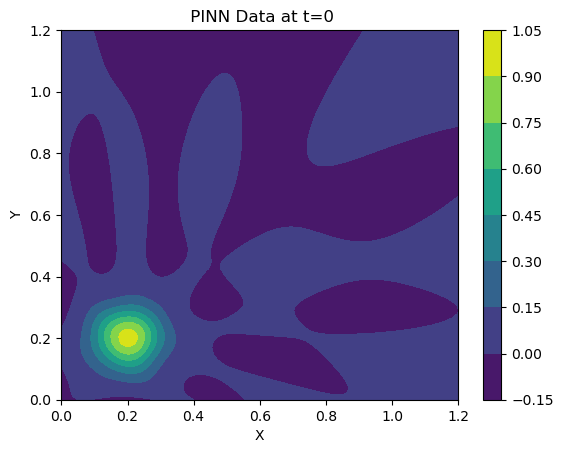

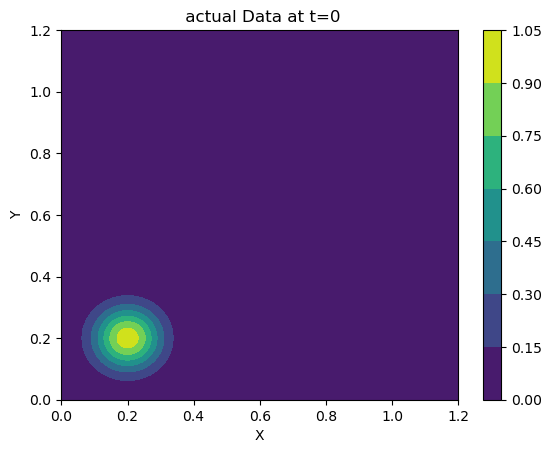

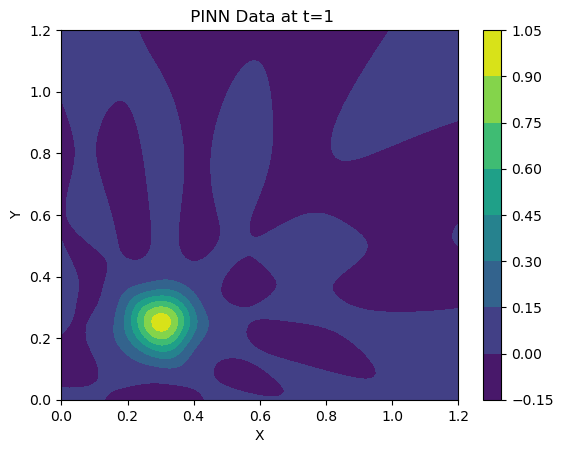

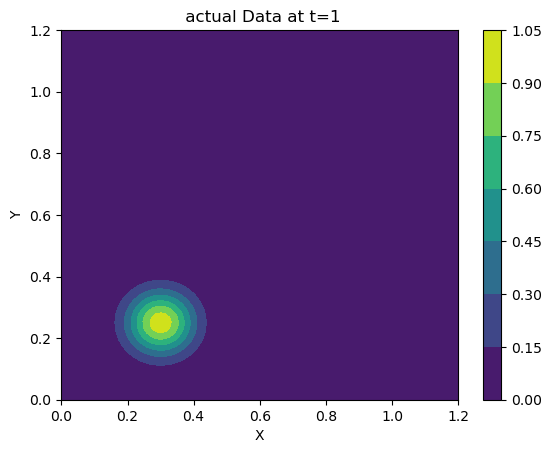

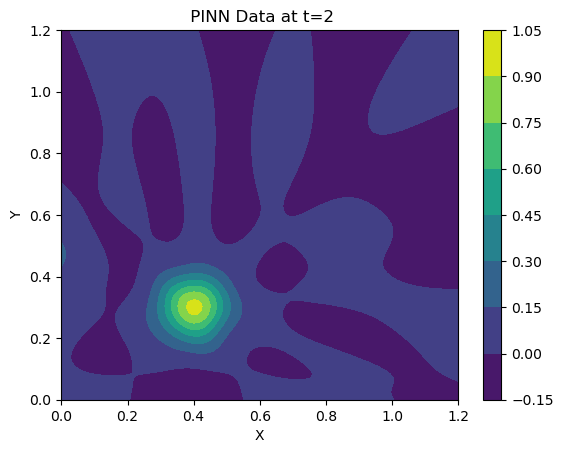

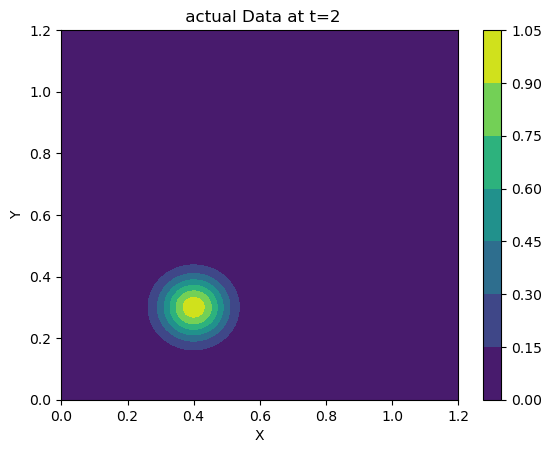

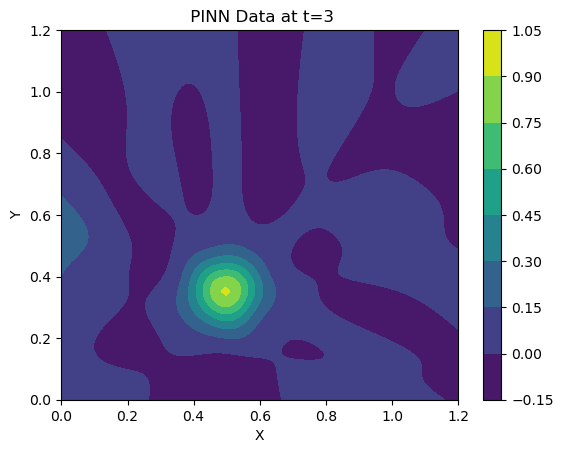

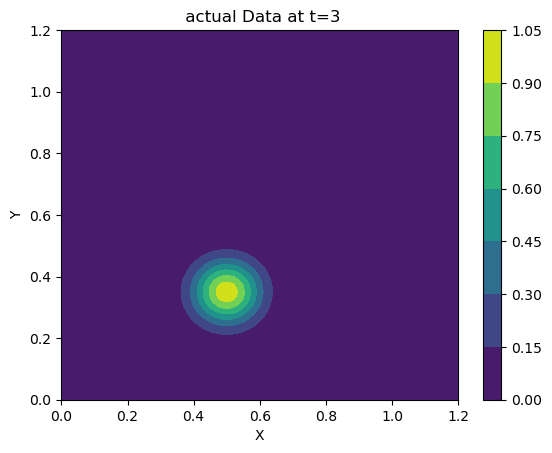

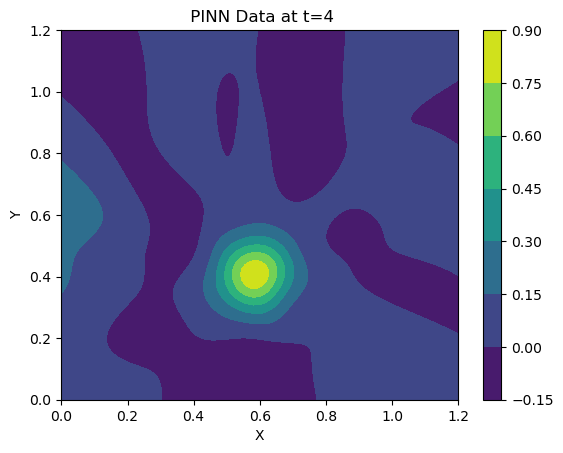

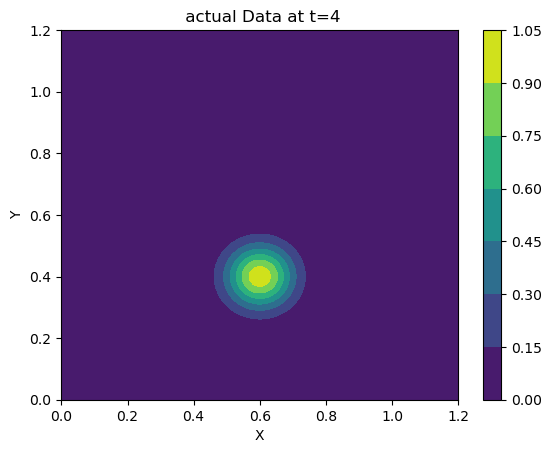

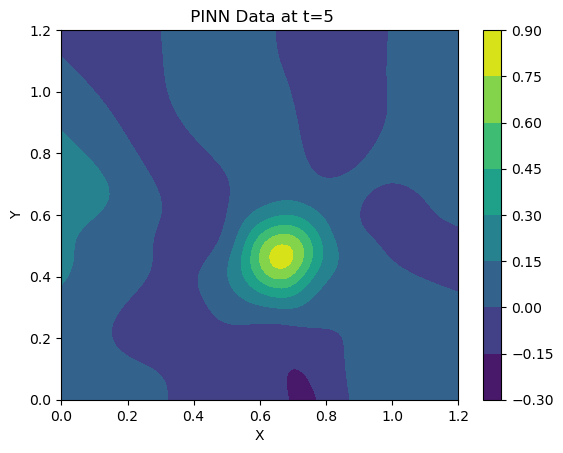

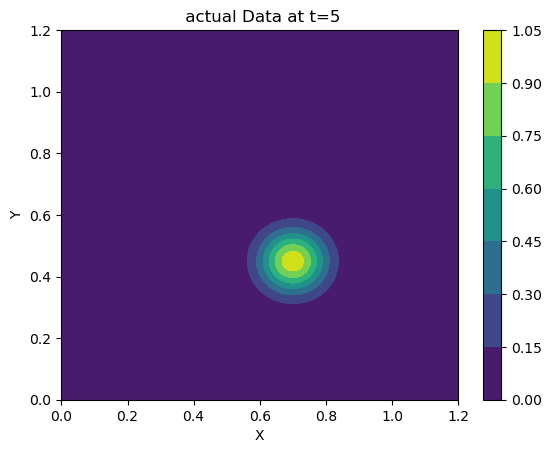

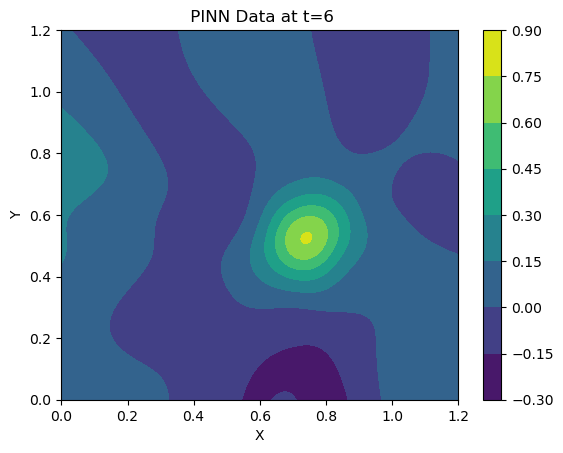

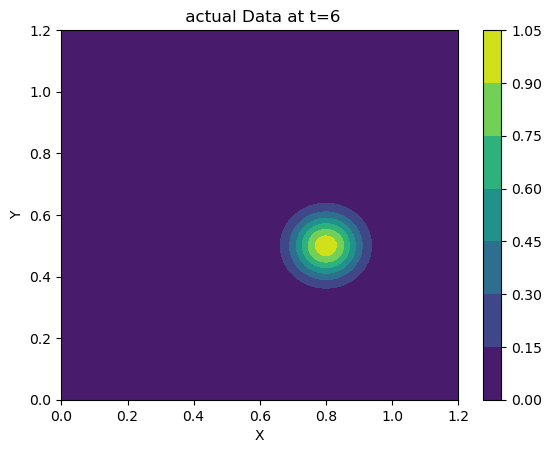

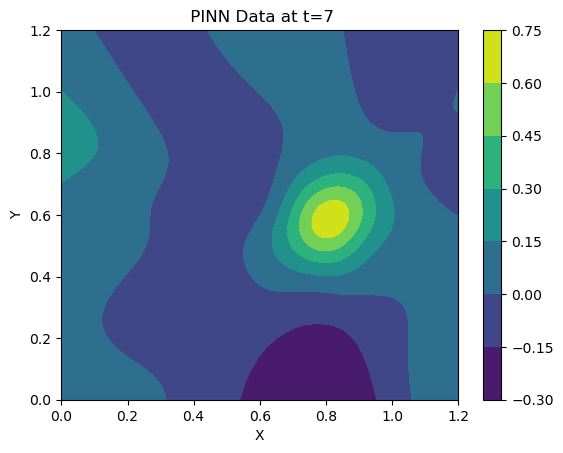

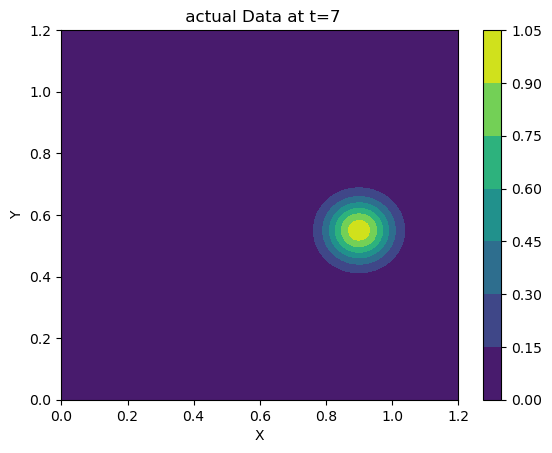

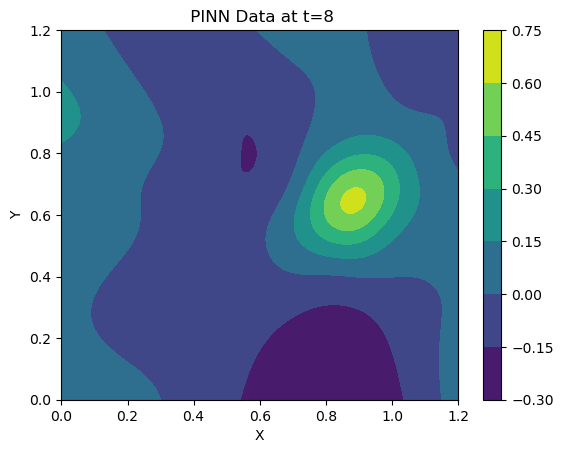

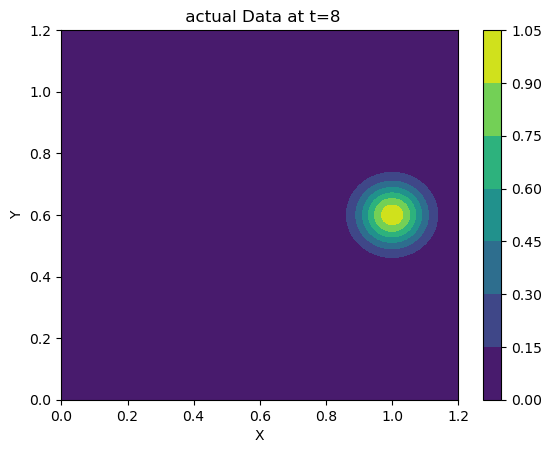

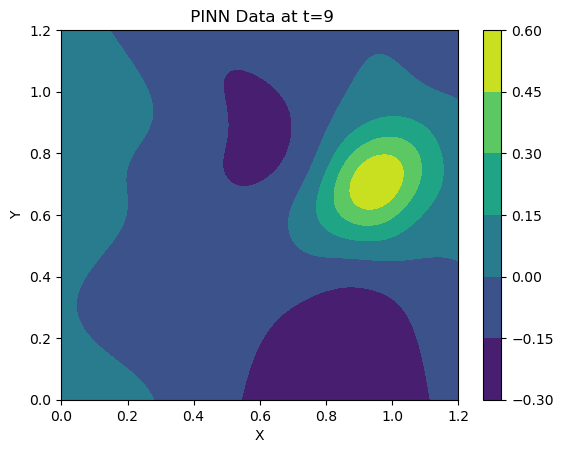

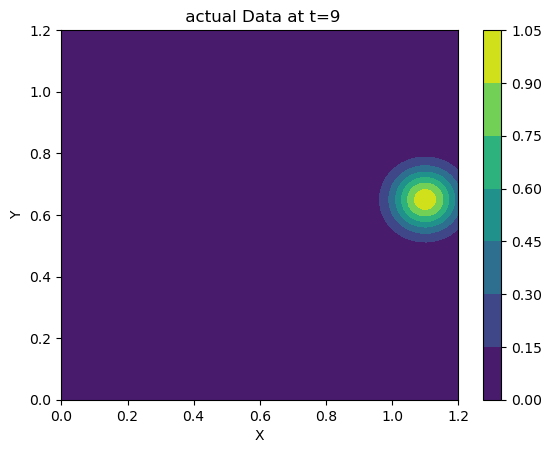

In [19]:
'''
Generate and save the plots for tt = 0-11
'''
cwd = os.getcwd()
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'pinn_plot')

# Create the directories if they don't exist
os.makedirs(nn_plot_dir, exist_ok=True)
os.makedirs(true_plot_dir, exist_ok=True)


nt = 10
xr = np.linspace(0,1.2,nx)
yr = np.linspace(0,1.2,ny)
tr = np.linspace(0,nt-1,nt).T
# print(f'xr: {xr} \n yr: {yr} \n tr: {tr}')
# print(f'xrshape: {xr.shape} \n yrshape: {yr.shape} \n trshape: {tr.shape}')
xrmesh , yrmesh, trmesh = np.meshgrid(xr,yr,tr)
# print(f'xrmesh: {xrmesh} \n yrmesh: {yrmesh} \n trmesh: {trmesh}')
#print(f'xrmeshshape: {xrmesh.shape} \n yrmeshshape: {yrmesh.shape} \n trmeshshape: {trmesh.shape}')


rin_test = np.stack((xrmesh, yrmesh, trmesh), axis=-1).reshape(-1, 3)
rin_test = torch.tensor(rin_test).float()
print(model(rin_test.float()).shape)
# Apply power transform
pt = PowerTransformer()
rin_test_np = rin_test.numpy()  # Convert to numpy array for sklearn

# Fit and transform the data
rin_test_transformed = pt.fit_transform(rin_test_np)

# Convert back to tensor
rin_test_transformed = torch.tensor(rin_test_transformed).float()

for tt in range(nt):
    ur = pinn(rin_test.float()).detach().numpy().reshape(nx,ny,nt)
    ut = u_2d_true(xrmesh,yrmesh,trmesh)
    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ur[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' PINN Data at t='+str(tt))
    plt.savefig(nn_plot_dir + '/pinn_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()

    plt.contourf(xrmesh[:,:,0], yrmesh[:,:,0], ut[:,:,tt])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(' actual Data at t='+str(tt))
    plt.savefig(true_plot_dir + '/true_plot_{}.png'.format(tt))
    plt.colorbar()
    plt.show()




# Save as GIFs

In [ ]:
import imageio
import os
import numpy as np
from skimage.transform import resize

# Set the directory paths for the true plot and neural network plot
true_plot_dir = os.path.join(cwd, '2d-advection', 'true_plot')
nn_plot_dir = os.path.join(cwd, '2d-advection', 'pinn_plot')

# Get the list of image files for both plots
true_plot_files = sorted([os.path.join(true_plot_dir, file) for file in os.listdir(true_plot_dir)])
nn_plot_files = sorted([os.path.join(nn_plot_dir, file) for file in os.listdir(nn_plot_dir)])

# Create a list to store the combined images
combined_images = []

# Iterate over the corresponding image files from both plots
for true_file, nn_file in zip(true_plot_files, nn_plot_files):
    # Read the true plot image
    true_image = imageio.imread(true_file)

    # Read the neural network plot image
    nn_image = imageio.imread(nn_file)

    # Resize the neural network plot image to match the dimensions of the true plot image
    nn_image_resized = resize(nn_image, true_image.shape[:2], anti_aliasing=True)

    # Concatenate the true plot and resized neural network plot images horizontally
    combined_image = np.concatenate((true_image, nn_image_resized), axis=1)

    # Convert the combined image to uint8 data type
    combined_image = (combined_image * 255).astype(np.uint8)

    # Reshape the combined image to (height, width, channels)
    combined_image = combined_image.reshape(combined_image.shape[:2] + (-1,))

    # Append the combined image to the list
    combined_images.append(combined_image)

# Set the output file path for the combined GIF
output_file = os.path.join(cwd, "2d_combined_pinn.gif")

# Save the combined images as a GIF
imageio.mimsave(output_file, combined_images, duration=1, loop=10, fps=1, subrectangles=True, palettesize=256)

In [ ]:
nx,ny,nt = 100,100,2

# Experiments


## Impact of making vx and vy as trainable parameters:

In [ ]:
torch.manual_seed(123)

# Create two instances of the PINN model, one with trainable vx and vy, and one without
pinn_trainable = FCN_iPINN(3, 1, 32, 3)
pinn_fixed = FCN_iPINN(3, 1, 32, 3)

# Make vx and vy non-trainable in the fixed model
pinn_fixed.velocity_x.requires_grad = False
pinn_fixed.velocity_y.requires_grad = False



physics_loss_trainable = []
physics_loss_fixed = []

nn_loss_trainable = []
nn_loss_fixed = []



mu_lr = 1e-1
print("The true value of Vx is: ", mux, "\n", "The initial guessed value of Vx is: ", pinn_trainable.velocity_x.item())
print("The true value of Vy is: ", muy, "\n", "The initial guessed value of Vy is: ", pinn_trainable.velocity_y.item())
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-4)

for i in range(5000):
    optimizer.zero_grad()
    
    # compute the "data loss"
    uh_tr = pinn_trainable(rin_data)
    uh_fx = pinn_fixed(rin_data)

    loss1_tr = torch.mean((uh_tr-rout_data)**2) # use mean squared error
    loss1_fx = torch.mean((uh_fx-rout_data)**2) # use mean squared error
    
    # compute the "physics loss"
    uhp_tr = pinn_trainable(rin_physics)
    uhp_fx = pinn_fixed(rin_physics)

    grad_tr = torch.autograd.grad(outputs=uhp_tr, inputs=rin_physics,grad_outputs=torch.ones_like(uhp_tr), create_graph=True)[0]
    grad_fx = torch.autograd.grad(outputs=uhp_fx, inputs=rin_physics,grad_outputs=torch.ones_like(uhp_fx), create_graph=True)[0]
    
    dudx_tr = grad_tr[:, 0]
    dudy_tr = grad_tr[:, 1]
    dudt_tr = grad_tr[:, 2]
    physics_tr = dudt_tr + pinn_trainable.velocity_x * dudx_tr + pinn_trainable.velocity_y * dudy_tr # this term is zero if the model output satisfies the advection equation

    dudx_fx = grad_fx[:, 0]
    dudy_fx = grad_fx[:, 1]
    dudt_fx = grad_fx[:, 2]
    physics_fx = dudt_fx + pinn_fixed.velocity_x * dudx_fx + pinn_fixed.velocity_y * dudy_fx # this term is zero if the model output satisfies the advection equation

    loss2_tr = torch.mean((physics_tr)**2)
    loss2_fx = torch.mean((physics_fx)**2)
   
    # backpropagate combined loss
    loss_tr = 2*loss1_tr + loss2_tr # add two loss terms together
    loss_fx = 2*loss1_fx + loss2_fx # add two loss terms together
    
    dJdvx_tr = torch.autograd.grad(loss_tr, pinn_trainable.velocity_x, retain_graph=True, create_graph = True)[0]
    pinn_trainable.velocity_x.data = pinn_trainable.velocity_x.data - (mu_lr * dJdvx_tr)
   

    dJdvy_tr = torch.autograd.grad(loss_tr, pinn_trainable.velocity_y, retain_graph=True, create_graph = True)[0]
    pinn_trainable.velocity_y.data = pinn_trainable.velocity_y.data - (mu_lr * dJdvy_tr)

    loss_tr.backward(retain_graph=True)
    loss_fx.backward(retain_graph=True)
    optimizer.step()

    physics_loss_trainable.append(loss2_tr.item())
    physics_loss_fixed.append(loss2_fx.item())
    nn_loss_trainable.append(loss1_tr.item())
    nn_loss_fixed.append(loss1_fx.item())
    

    if (i+1) % 1000 == 0:
            print(f'Epoch: {i+1}/{10000}, Loss Trainable Vx,Vy : {loss_tr.item()}')
            print(f'Epoch: {i+1}/{10000}, Loss Fixed Vx,Vy : {loss_fx.item()}')
            print("At itteration: ", i, "\n", "The current value of Vx is: ", pinn_trainable.velocity_x.item())
            print("At itteration: ", i, "\n", "The current value of Vy is: ", pinn_fixed.velocity_y.item())
            print(f'Trainable NN loss : {loss1_tr.item()}, Physics loss : {loss2_tr.item()}')
            print(f'Fixed NN loss : {loss1_fx.item()}, Physics loss : {loss2_fx.item()}')


In [ ]:
# Plot the results of the PINN with trainable vx and vy and the PINN with fixed vx and vy


# Convert the losses to numpy arrays
physics_loss_trainable_np = np.array(physics_loss_trainable)
physics_loss_fixed_np = np.array(physics_loss_fixed)
nn_loss_trainable_np = np.array(nn_loss_trainable)
nn_loss_fixed_np = np.array(nn_loss_fixed)

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot the physics losses
plt.subplot(2, 1, 1)
plt.plot(physics_loss_trainable_np, label='Trainable Vx, Vy Physics Loss')
plt.plot(physics_loss_fixed_np, label='Fixed Vx, Vy Physics Loss')
plt.yscale('log')
plt.title('Physics Loss')
plt.legend()

# Plot the neural network losses
plt.subplot(2, 1, 2)
plt.plot(nn_loss_trainable_np, label='Trainable Vx, Vy NN Loss')
plt.plot(nn_loss_fixed_np, label='Fixed Vx, Vy NN Loss')
plt.yscale('log')
plt.title('Neural Network Loss')
plt.legend()

# Show the plot
plt.show()



## Analysing Sensitivity of physics loss wrt grid values:

In [ ]:
torch.manual_seed(123)


# Create a mask for grid points with no change
no_change_mask = np.abs(np.diff(rout_data2, axis=-1)) < 1e-3


print(f'Number of grid points with no change: {np.sum(no_change_mask)}')
print(f'Number of grid points with change: {np.sum(~no_change_mask)}')
print('no change shape', no_change_mask.shape)
print('rout_data2 shape', rout_data2.shape)
torch.manual_seed(123)

# Train the PINN model and compute the physics loss for each grid point
physics_losses = []
change_losses = []
no_change_losses = []
nn_losses = []
pinn = FCN_iPINN(3, 1, 32, 3)
mu_lr = 1e-3

print("The true value of Vx is: ", mux, "\n", "The initial guessed value of Vx is: ", pinn.velocity_x.item())
print("The true value of Vy is: ", muy, "\n", "The initial guessed value of Vy is: ", pinn.velocity_y.item())

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

for i in range(5000):
    optimizer.zero_grad()

    # compute the "data loss"
    uh = pinn(rin_data)
    loss1 = torch.mean((uh-rout_data)**2) # use mean squared error

    # Sample the same number of random points as the total number of grid points
    rin_physics = np.random.uniform(size=(nx*ny*nt, 3))
    rin_physics[:, 2] *= nt
    rin_physics = torch.tensor(rin_physics).float().requires_grad_(True)

    # compute the "physics loss"
    uhp = pinn(rin_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics,
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]

    physics = dudt + pinn.velocity_x * dudx + pinn.velocity_y * dudy # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean((physics)**2)

    # backpropagate combined loss
    loss = loss1 + loss2 # add two loss terms together

    dJdvx = torch.autograd.grad(loss, pinn.velocity_x, retain_graph=True, create_graph=True)[0]
    pinn.velocity_x.data = pinn.velocity_x.data - (mu_lr * dJdvx)

    dJdvy = torch.autograd.grad(loss, pinn.velocity_y, retain_graph=True, create_graph=True)[0]
    pinn.velocity_y.data = pinn.velocity_y.data - (mu_lr * dJdvy)

    loss.backward(retain_graph=True)
    optimizer.step()


    # Calculate average physics loss for grid points with and without change
    physics_losses_array = physics.detach().numpy().reshape(nx, ny, nt)
    
    
    no_change_mask_expanded = np.expand_dims(no_change_mask, axis=-1)  # Expand dimensions of no_change_mask
   
    change_loss = np.mean(physics_losses_array[:, :, :-1][~no_change_mask_expanded.squeeze()])
    no_change_loss = np.mean(physics_losses_array[:, :, :-1][no_change_mask_expanded.squeeze()])
    change_losses.append(change_loss)
    no_change_losses.append(no_change_loss)
    nn_losses.append(loss1.item())

    if (i+1) % 1000 == 0:
        print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
        print("At iteration: ", i, "\n", "The current value of Vx is: ", pinn.velocity_x.item())
        print("At iteration: ", i, "\n", "The current value of Vy is: ", pinn.velocity_y.item())
        print(f' NN loss : {loss1.item()}, Physics loss : {loss2.item()}')



print(f'Average physics loss for grid points with change: {change_loss}')
print(f'Average physics loss for grid points without change: {no_change_loss}')


### Plot the results

In [ ]:

# Convert the losses to numpy arrays
physics_loss = np.array(physics_losses)
nn_loss = np.array(nn_losses)
change_loss = np.array(change_losses)
no_change_loss = np.array(no_change_losses)


# Create a new figure
plt.figure(figsize=(10, 8))

# Plot the physics losses
plt.subplot(2, 1, 1)
plt.plot(physics_loss, label='Trainable Vx, Vy Physics Loss')
plt.plot(nn_loss, label='Trainable Vx,Vy NN Loss')
plt.yscale('log')
plt.title('Loss')
plt.legend()

# plot the physics losses for grid points with and without change
plt.subplot(2, 1, 2)
plt.plot(change_loss, label='Loss at Grid points with change')
plt.plot(no_change_loss, label='Loss at Grid points without change')
plt.yscale('log')
plt.title('Physics Loss for Grid Points with and without Change')
plt.legend()


# Show the plot
plt.show()


## Dynamically changing grid to follow pattern movement:

In [ ]:
torch.manual_seed(123)

# Implement a function to dynamically update the grid based on pattern movement
def update_grid(rout_data2):
    # Identify the pattern center at each time step
    pattern_center = np.unravel_index(np.argmax(rout_data2, axis=None), rout_data2.shape[:2])

    # Update the grid to center around the pattern
    new_xr = np.linspace(pattern_center[0] - 0.5, pattern_center[0] + 0.5, nx)
    new_yr = np.linspace(pattern_center[1] - 0.5, pattern_center[1] + 0.5, ny)
    new_tr = np.linspace(0, nt - 1, nt).T

    new_xrmesh, new_yrmesh, new_trmesh = np.meshgrid(new_xr, new_yr, new_tr)
    new_rin_physics = np.stack((new_xrmesh, new_yrmesh, new_trmesh), axis=-1).reshape(-1, 3)
    new_rin_physics = torch.tensor(new_rin_physics).float().requires_grad_(True)

    return new_rin_physics

physics_loss = []
nn_loss = []

pinn = FCN_iPINN(3, 1, 32, 3)
mu_lr = 1e-3

print("The true value of Vx is: ", mux, "\n", "The initial guessed value of Vx is: ", pinn.velocity_x.item())
print("The true value of Vy is: ", muy, "\n", "The initial guessed value of Vy is: ", pinn.velocity_y.item())

optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)

for i in range(5000):
    optimizer.zero_grad()

    # compute the "data loss"
    uh = pinn(rin_data)
    loss1 = torch.mean((uh-rout_data)**2) # use mean squared error

    # compute the "physics loss"
    rin_physics = update_grid(rin_physics, rout_data2)
    uhp = pinn(rin_physics)
    grad = torch.autograd.grad(outputs=uhp, inputs=rin_physics,
                               grad_outputs=torch.ones_like(uhp), create_graph=True)[0]
    dudx = grad[:, 0]
    dudy = grad[:, 1]
    dudt = grad[:, 2]

    physics = dudt + pinn.velocity_x * dudx + pinn.velocity_y * dudy # this term is zero if the model output satisfies the advection equation
    loss2 = torch.mean((physics)**2)

    # backpropagate combined loss
    loss = 2*loss1 + loss2 # add two loss terms together

    dJdvx = torch.autograd.grad(loss, pinn.velocity_x, retain_graph=True, create_graph=True)[0]
    pinn.velocity_x.data = pinn.velocity_x.data - (mu_lr * dJdvx)

    dJdvy = torch.autograd.grad(loss, pinn.velocity_y, retain_graph=True, create_graph=True)[0]
    pinn.velocity_y.data = pinn.velocity_y.data - (mu_lr * dJdvy)

    loss.backward(retain_graph=True)
    optimizer.step()

    physics_loss.append(loss2.item())
    nn_loss.append(loss1.item())

    if (i+1) % 1000 == 0:
        print(f'Epoch: {i+1}/{10000}, Loss: {loss.item()}')
        print("At iteration: ", i, "\n", "The current value of Vx is: ", pinn.velocity_x.item())
        print("At iteration: ", i, "\n", "The current value of Vy is: ", pinn.velocity_y.item())
        print(f' NN loss : {loss1.item()}, Physics loss : {loss2.item()}')

### Plot the results

In [ ]:
# Plot the results of the PINN with trainable vx and vy and the PINN with fixed vx and vy


# Convert the losses to numpy arrays
physics_loss = np.array(physics_loss)
nn_loss = np.array(nn_loss)

# Create a new figure
plt.figure(figsize=(10, 8))

# Plot the physics losses
plt.plot(physics_loss, label='Trainable Vx, Vy Physics Loss')
plt.plot(nn_loss, label='Trainable Vx,Vy NN Loss')
plt.yscale('log')
plt.title('Loss')
plt.legend()



# Show the plot
plt.show()


In [ ]:
# Pre-training to find relationship between NN loss and physics loss
